## Imports

In [3]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.gridspec import GridSpec

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Testing KMeans

torch.Size([10, 2, 2])


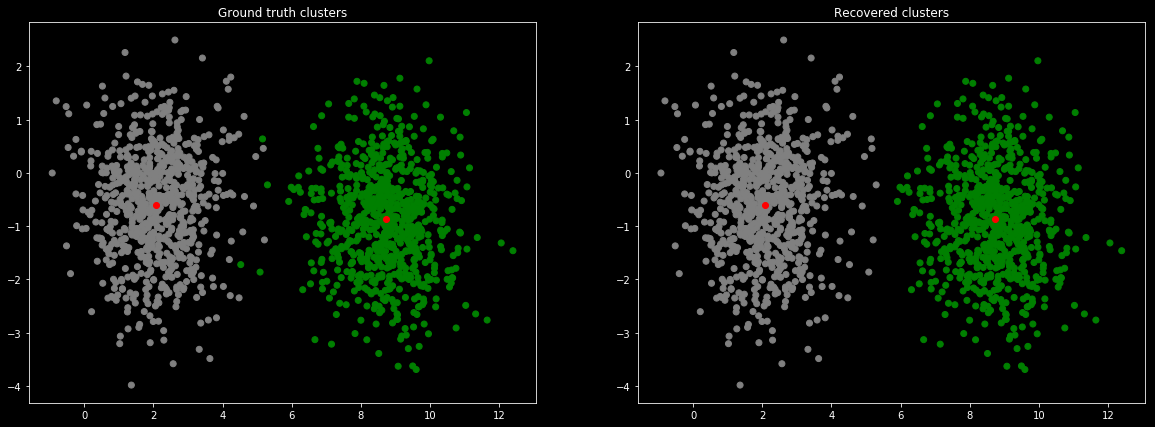

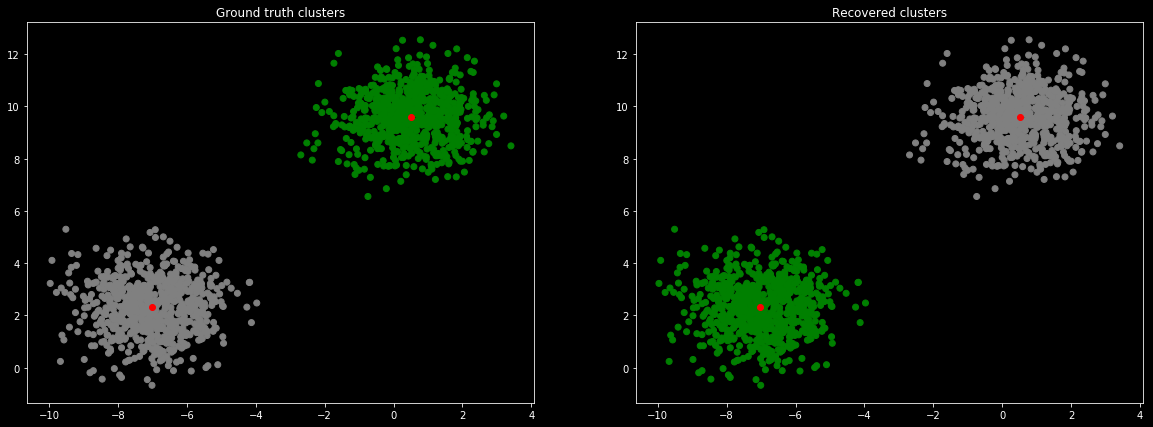

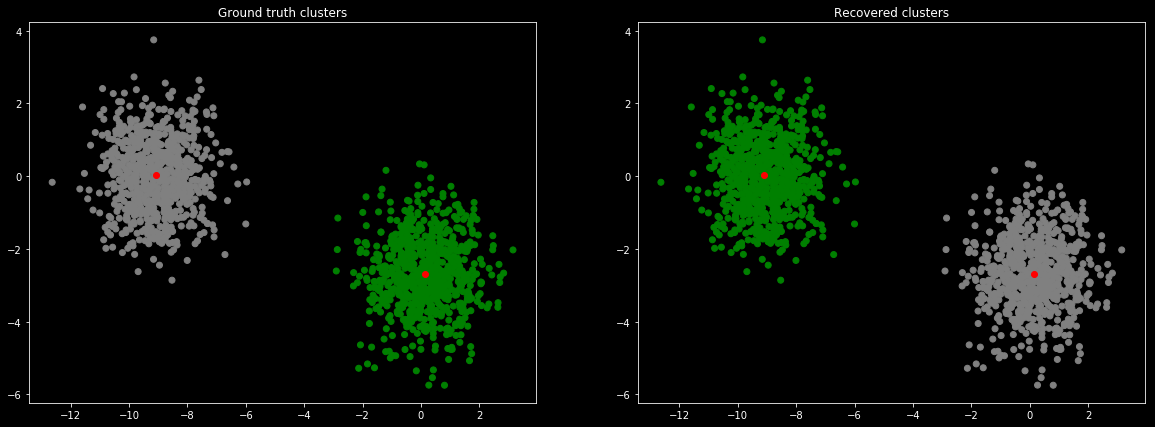

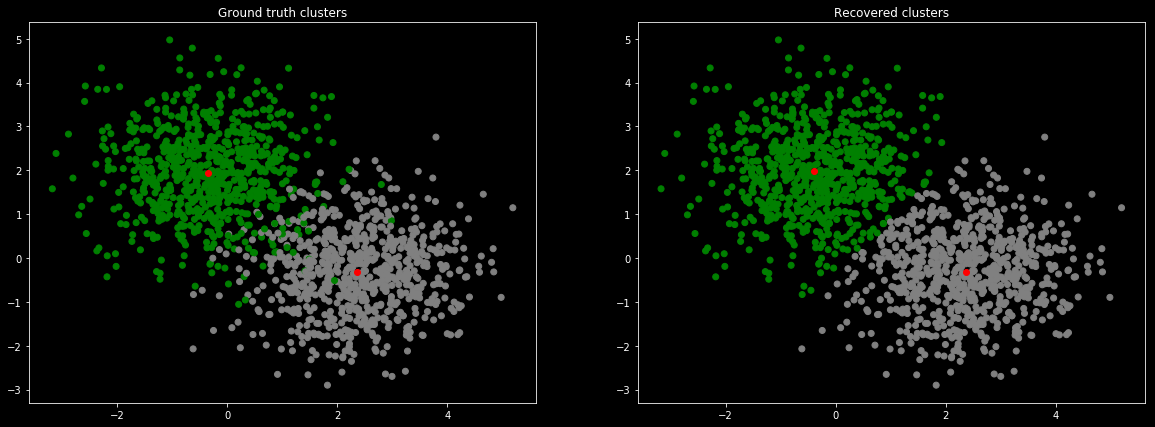

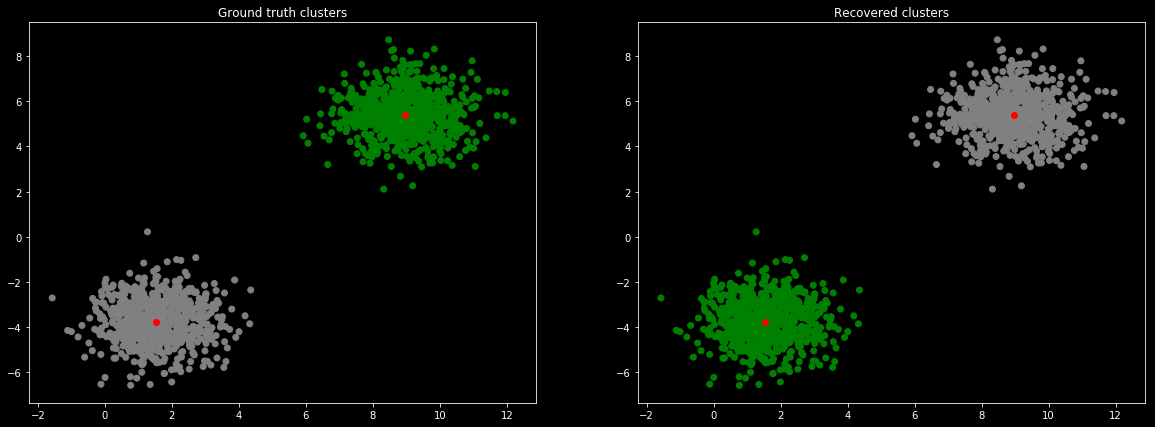

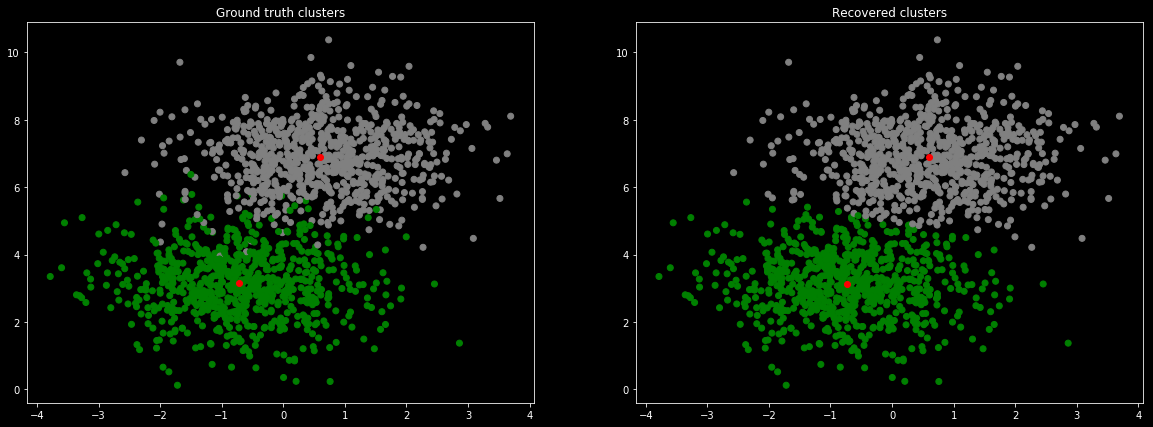

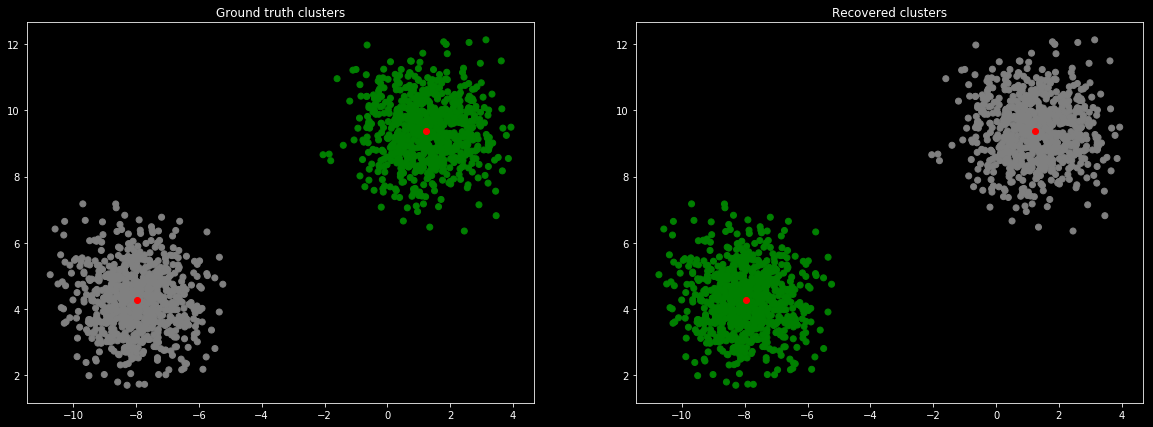

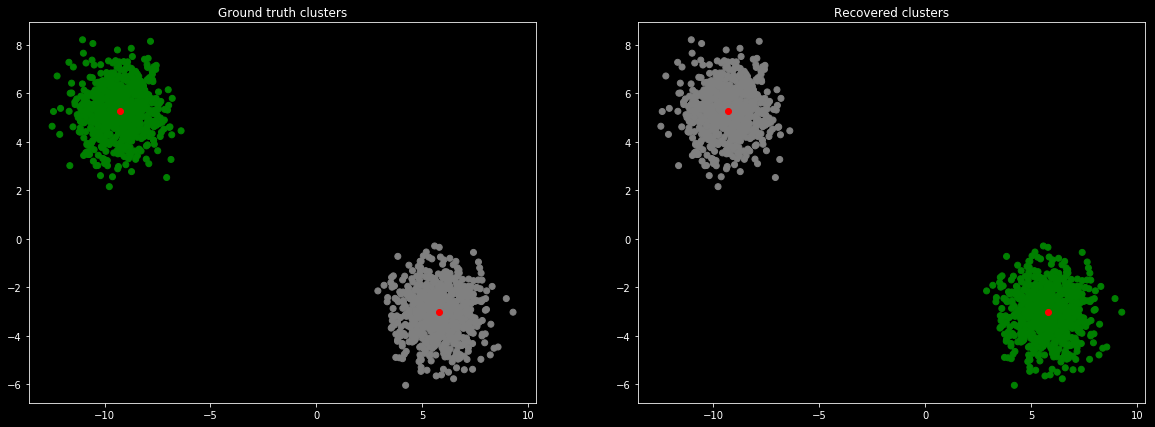

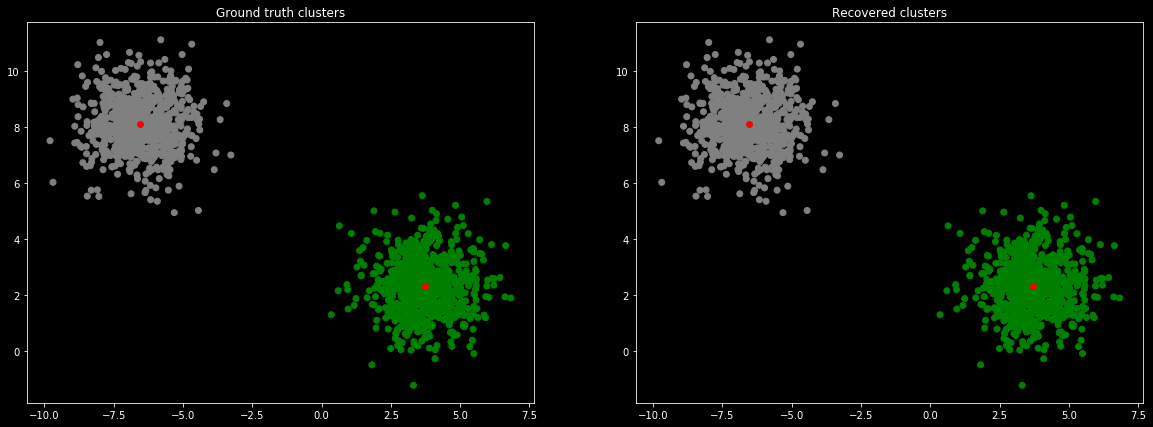

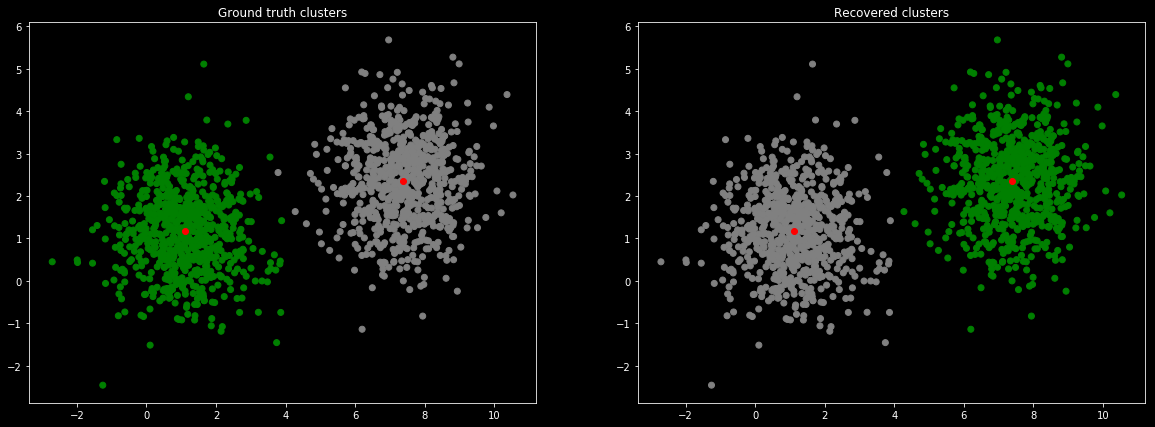

In [4]:
import kmeans
reload(kmeans)
from kmeans import KMeans

plt.style.use('dark_background')

n_batches = 10
n_samples = 1500
n_clusters = 2
n_features = 2

plot = True
downsample = 1

data = []
labels = []
actual_means = []

for n_batch in range(n_batches):
    random_state = np.random.seed()
    data_, labels_ = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, random_state=random_state)
    actual_means_ = np.stack([np.mean(data_[labels_ == i], axis=0) for i in range(n_clusters)])
    data.append(data_)
    labels.append(labels_)
    actual_means.append(actual_means_)

data = np.stack(data)
labels = np.stack(labels)
actual_means = np.stack(actual_means)
    
data_tensor = torch.from_numpy(data).contiguous().float().to(device)
weights = data_tensor.new((np.ones(data_tensor.shape[:-1])).astype(np.float))
k_means = KMeans(n_clusters=n_clusters, n_iterations=5, alpha=10, init_method='random').to(device)
assignments, means = k_means(data_tensor, weights=weights)
print(means.shape)
means = means.cpu().data.numpy()
assignments = assignments.cpu().data.numpy()
transform = PCA(n_components=2)

if plot:
    colors = ['gray', 'green', 'blue', 'cyan', 'magenta', 'white', 'yellow']
    for i in range(n_batches):
        
        x = np.vstack([data[i, :, :], actual_means[i, :, :], means[i, :, :]])
        y = x #transform.fit_transform(x)
        d = y[:data.shape[1], :]
        am = y[data.shape[1]:data.shape[1]+actual_means.shape[1], :]
        m = y[data.shape[1]+actual_means.shape[1]:, :]
        
        c = [colors[l] for l in labels[i]]
        plt.figure(figsize=(20, 7))
        plt.subplot(121)
        plt.scatter(d[::downsample, 0], d[::downsample, 1], color=c[::downsample])
        plt.title('Ground truth clusters')
        plt.scatter(am[:, 0], am[:, 1], color='red')

        c = [colors[l] for l in np.argmax(assignments[i], axis=-1)]
        plt.subplot(122)
        plt.scatter(d[::downsample, 0], d[::downsample, 1], color=c[::downsample])
        plt.title('Recovered clusters')
        plt.scatter(m[:, 0], m[:, 1], color='red')
        plt.show()

### Testing GMMs

(2137, 2) (2137,)


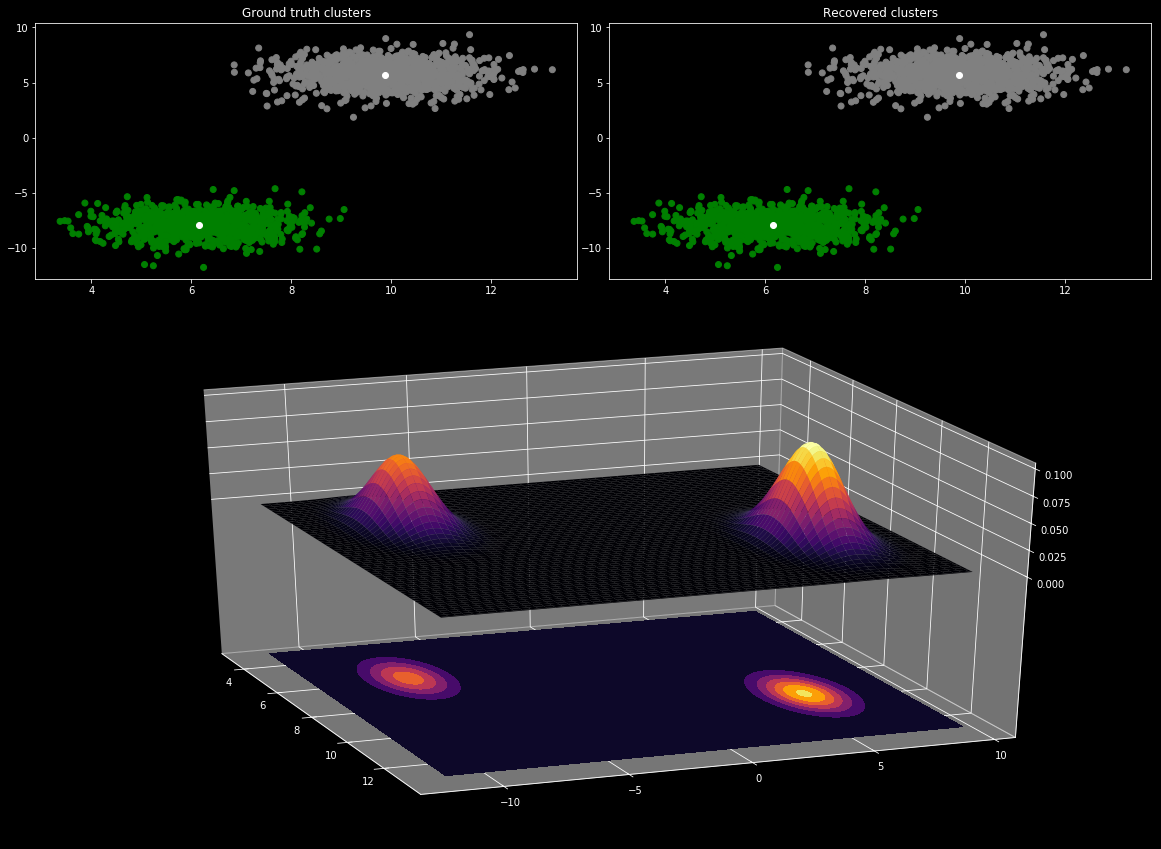

In [5]:
import gmm
reload(gmm)
from gmm import GMM

plt.style.use('dark_background')

n_batches = 1
n_samples = 1500
n_clusters = 2
n_features = 2

plot = True
downsample = 1

data = []
labels = []
actual_means = []

def make_clusters():
    random_state = np.random.seed()
    d = []
    l = []
    for i in range(n_clusters):
        n_samples_ = np.random.randint(int(n_samples / 5), n_samples)
        std_ = 1.0 #np.random.uniform(.2, 1.0)
        data_, labels_ = make_blobs(n_samples=n_samples_, centers=1, cluster_std=std_, n_features=n_features, random_state=random_state)
        d.append(data_)
        l.append(labels_ + i)
    data_ = np.vstack(d)
    labels_ = np.hstack(l)
    print(data_.shape, labels_.shape)
    return data_, labels_

for n_batch in range(n_batches):
    random_state = 130
    #data_, labels_ = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, random_state=random_state)
    data_, labels_ = make_clusters()
    actual_means_ = np.stack([np.mean(data_[labels_ == i], axis=0) for i in range(n_clusters)])
    data.append(data_)
    labels.append(labels_)
    actual_means.append(actual_means_)

data = np.stack(data)
labels = np.stack(labels)
actual_means = np.stack(actual_means)    
    
data_tensor = torch.from_numpy(data).contiguous().float().to(device)
weights = data_tensor.new((np.ones(data_tensor.shape[:-1])).astype(np.float))
gmm = GMM(n_clusters=n_clusters, n_iterations=5, covariance_type='tied_spherical').to(device)
output = gmm(data_tensor)
output = [output[0]] + [output[1]] + [x for x in output[-1]]
assignments, posteriors, means, var, pi = [x.cpu().data.numpy() for x in output]
transform = PCA(n_components=2)

def get_density(mu, var, pi, N=50, X_range=(0, 5), Y_range=(0, 5)):
    """ Get the mesh to compute the density on. """
    X = np.linspace(*X_range, N)
    Y = np.linspace(*Y_range, N)
    X, Y = np.meshgrid(X, Y)
    
    # get the design matrix
    points = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    points = torch.from_numpy(points).float().unsqueeze(0)
    mu = torch.from_numpy(mu).unsqueeze(0).float()
    var = torch.from_numpy(var).unsqueeze(0).float()
    pi = torch.from_numpy(pi).unsqueeze(0).float()
    # compute the densities under each mixture
    P = gmm.update_likelihoods(points, mu, var, pi).squeeze(0).exp()

    # sum the densities to get mixture density
    Z = torch.sum(P, dim=0).data.numpy().reshape([N, N])
    
    return X, Y, Z

def plot_density(X, Y, Z, i=0):
    ax = plt.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.inferno)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.inferno)

    # adjust the limits, ticks and view angle
    z_max = .1
    ax.set_zlim(-0.15,z_max)
    ax.set_zticks(np.linspace(0, z_max, 5))
    ax.view_init(27, -21)

if plot:
    colors = ['gray', 'green', 'blue', 'cyan', 'magenta', 'white', 'yellow']
    for i in range(n_batches):
        
        x = np.vstack([data[i, :, :], actual_means[i, :, :], means[i, :, :]])
        y = x
        if n_features > 2:
            y = transform.fit_transform(y)
        d = y[:data.shape[1], :]
        am = y[data.shape[1]:data.shape[1]+actual_means.shape[1], :]
        m = y[data.shape[1]+actual_means.shape[1]:, :]
        v = var[i, :, :]
        p = pi[i, :]
        mx = means[i, :, :]
        #all_means = np.vstack([me[i, :, :].cpu().data.numpy() for me in gmm.means])
        
        c = [colors[l] for l in labels[i]]
        plt.figure(figsize=(20, 15))
        gs = GridSpec(6, 6)
        plt.subplot(gs[:2, :3])
        plt.scatter(d[::downsample, 0], d[::downsample, 1], color=c[::downsample])
        plt.title('Ground truth clusters')
        plt.scatter(am[:, 0], am[:, 1], color='white')

        c = [colors[l] for l in np.argmax(assignments[i], axis=-1)]
        plt.subplot(gs[:2, 3:])
        plt.scatter(d[::downsample, 0], d[::downsample, 1], color=c[::downsample])
        plt.title('Recovered clusters')
        #plt.scatter(all_means[:, 0], all_means[:, 1], color='red')
        plt.scatter(m[:, 0], m[:, 1], color='white')
        
        
        if n_features == 2:
            plt.subplot(gs[2:, :], projection='3d')
            plot_density(*get_density(m, v, p, N=200, X_range=(d[::downsample, 0].min(), d[::downsample, 0].max()), 
                                      Y_range=(d[::downsample, 1].min(), d[::downsample, 1].max())), i=0)
            plt.show()

In [95]:
means, var

(array([[[ 0.3396357 , -8.316094  ],
         [ 0.20656927, -0.7807168 ]]], dtype=float32),
 array([[[0.97017753, 0.97017753],
         [0.97017753, 0.97017753]]], dtype=float32))

In [111]:
assignments.max(), assignments.min(), posteriors.max(), posteriors.min()

(0.12613118, 1.4754763e-15, 1.0, 1.04569105e-11)

In [83]:
assignments.min(), assignments.max()

(0.0, 1.0)

In [93]:
gmm = GMM(n_clusters=n_clusters, n_iterations=5)
from scipy.stats import multivariate_normal

def np_(var):
    """ helper fn for var -> numpy"""
    return var.data.numpy()

def test_likelihood_fn():
    """
    Checks that the computed densities match those given
    by the scipy implementation.
    """
    X = torch.randn(4, 3)

    mu = torch.Tensor([
        [0.3, -0.1, 0.4],
        [0.1, -0.2, 0.7]
    ])

    var = torch.Tensor([
        [0.3, 1., 0.8],
        [0.1, 2., 1.2],
    ])
    
    pi = torch.Tensor([
        [1, 1]
    ])
    
    print(mu.shape, var.shape, pi.shape)

    K = mu.size(0)

    # compute likelihoods
    P1 = gmm.update_likelihoods(X.unsqueeze(0), mu.unsqueeze(0), var.unsqueeze(0), pi.unsqueeze(0)).data.squeeze(0).numpy()

    P2 = []
    for k in range(K):
        P2 += [
            multivariate_normal.pdf(np_(X), mean=np_(mu[k]), cov=np_(var[k].diag()))
        ]
    P2 = np.array(P2)
    print(P2)
    P2 = np.exp(np.log(P2))
    P1 = np.exp(P1)
    # assert equality
    print(P1, P2)
    assert np.allclose(P1, P2)

test_likelihood_fn()

torch.Size([2, 3]) torch.Size([2, 3]) torch.Size([1, 2])
[[1.39891893e-05 1.18870537e-02 9.00649200e-04 1.08176401e-02]
 [6.72503484e-09 3.59048424e-03 4.88268738e-06 9.04479962e-03]]
[[[1.39891845e-05 1.18870540e-02 9.00649058e-04 1.08176414e-02]
  [6.72503564e-09 3.59048345e-03 4.88268415e-06 9.04479809e-03]]] [[1.39891893e-05 1.18870537e-02 9.00649200e-04 1.08176401e-02]
 [6.72503484e-09 3.59048424e-03 4.88268738e-06 9.04479962e-03]]
